<a href="https://colab.research.google.com/github/kdats/mlp_vs_cnn_model/blob/main/Copy_of_AIAS_B3_M2_MP1_NB_Traffic_sign_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Mini Project: Image classification using MLP and CNN

## Learning Objectives

At the end of the experiment, you will be able to :

* load and extract features of images

* implement the Multi-Layer perceptron to classify images

* implement CNN using keras

## Introduction

Traffic sign recognition is a challenging, real-world problem relevant for AI based transportation systems. Traffic signs show a wide range of variations between classes in terms of color, shape, and the presence of pictograms or text. However, there exist subsets of
classes (e.g., speed limit signs) that are very similar to each other. Further, the classifier
has to be robust against large variations in visual appearances due to changes in illumination, partial
occlusions, rotations, weather conditions etc. Using a comprehensive traffic sign detection dataset, here we will perform classification of traffic signs, train and evaluate the different models and compare to the performance of MLPs.

![img](https://paperswithcode.com/media/datasets/GTSRB-0000000633-9ce3c5f6_Dki5Rsf.jpg)

## Dataset

The data for this mini-project is from the German Traffic Sign Detection Benchmark [GTSDB](https://benchmark.ini.rub.de/gtsdb_dataset.html). This archive contains the training set used during the IJCNN 2013 competition.

The German Traffic Sign Detection Benchmark is a single-image detection assessment for researchers with interest in the field of computer vision, pattern recognition and image-based driver assistance. It is introduced on the IEEE International Joint Conference on Neural Networks 2013.

It features ...

* The main archive FullIJCNN2013.zip includes the images (1360 x 800 pixels) in PPM format, the image sections containing only the traffic signs
* A file in CSV format with the ground truth
* A ReadMe.txt with more details.

## Problem Statement

To build and improve upon a machine learning model for the classification of images and achieve a high accuracy final model.

## Grading = 10 Points

In [6]:
#@title Download the data
!wget -qq https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip


^C
[FullIJCNN2013.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of FullIJCNN2013.zip or
        FullIJCNN2013.zip.zip, and cannot find FullIJCNN2013.zip.ZIP, period.


In [12]:
!unzip -qq /content/FullIJCNN2013.zip.2 -d /content/FullIJCNN2013/



### Import Required packages

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from skimage.io import imread, imshow
from sklearn import preprocessing
import os, glob
from PIL import Image
from sklearn.model_selection import GridSearchCV
# Keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

###**Excercise 1**

### Data Loading and Feature Extraction (1 points)

#### Get the features and labels of data

* Extract the features of the images
* Extract labels of the images
* Resize the images to (30, 30) and convert to numpy 1-D array

   Hint: [Link](https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/)

In [80]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# Path to the dataset
data_path = "/content/FullIJCNN2013/FullIJCNN2013/"
gt_file_path = os.path.join(data_path, "gt.txt")  # Ground truth file

# Read the ground truth file
gt_data = pd.read_csv(gt_file_path, sep=";", header=None)
gt_data.columns = ["Filename", "LeftCol", "TopRow", "RightCol", "BottomRow", "ClassID"]

# Initialize lists to store features and labels
features = []
labels = []

# Preprocess the images
resize_dim = (30, 30)  # Resize dimension for all traffic signs

# Extract ROIs (regions of interest) and labels
for _, row in gt_data.iterrows():
    try:
        # Load the full image
        img_path = os.path.join(data_path, row["Filename"])
        img = Image.open(img_path)

        # Crop the ROI
        roi = img.crop((row["LeftCol"], row["TopRow"], row["RightCol"], row["BottomRow"]))

        # Resize the ROI
        roi_resized = roi.resize(resize_dim)

        # Convert to NumPy array
        roi_array = np.array(roi_resized)

        # Append to features and labels
        features.append(roi_array)
        labels.append(row["ClassID"])
    except Exception as e:
        print(f"Error processing file {row['Filename']}: {e}")

# Convert features and labels to NumPy arrays
features = np.array(features)
labels = np.array(labels)

# Normalize the features
features = features / 255.0  # Scale pixel values to range [0, 1]



In [49]:
# Plot a sample image for each class
unique_classes = np.unique(labels)
class_samples = {}

# Collect one sample image per class
for class_id in unique_classes:
    idx = np.where(labels == class_id)[0][0]  # Get the first occurrence of each class
    class_samples[class_id] = features[idx]


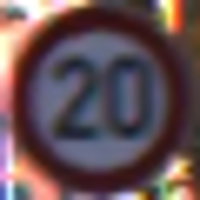

In [51]:
test_class_id = 0  # Choose the class ID you want to test (e.g., 0 for speed limit 20)
test_image_array = class_samples[test_class_id]  # Extract the sample image for the class

# Convert NumPy array back to an image using PIL
test_image = Image.fromarray((test_image_array * 255).astype(np.uint8))
test_image.resize((200, 200))

###**Excercise 2**
### Data Exploration and Preprocessing ( 2 points)

#### Plot the sample image of each class

Hint: plt.subplot

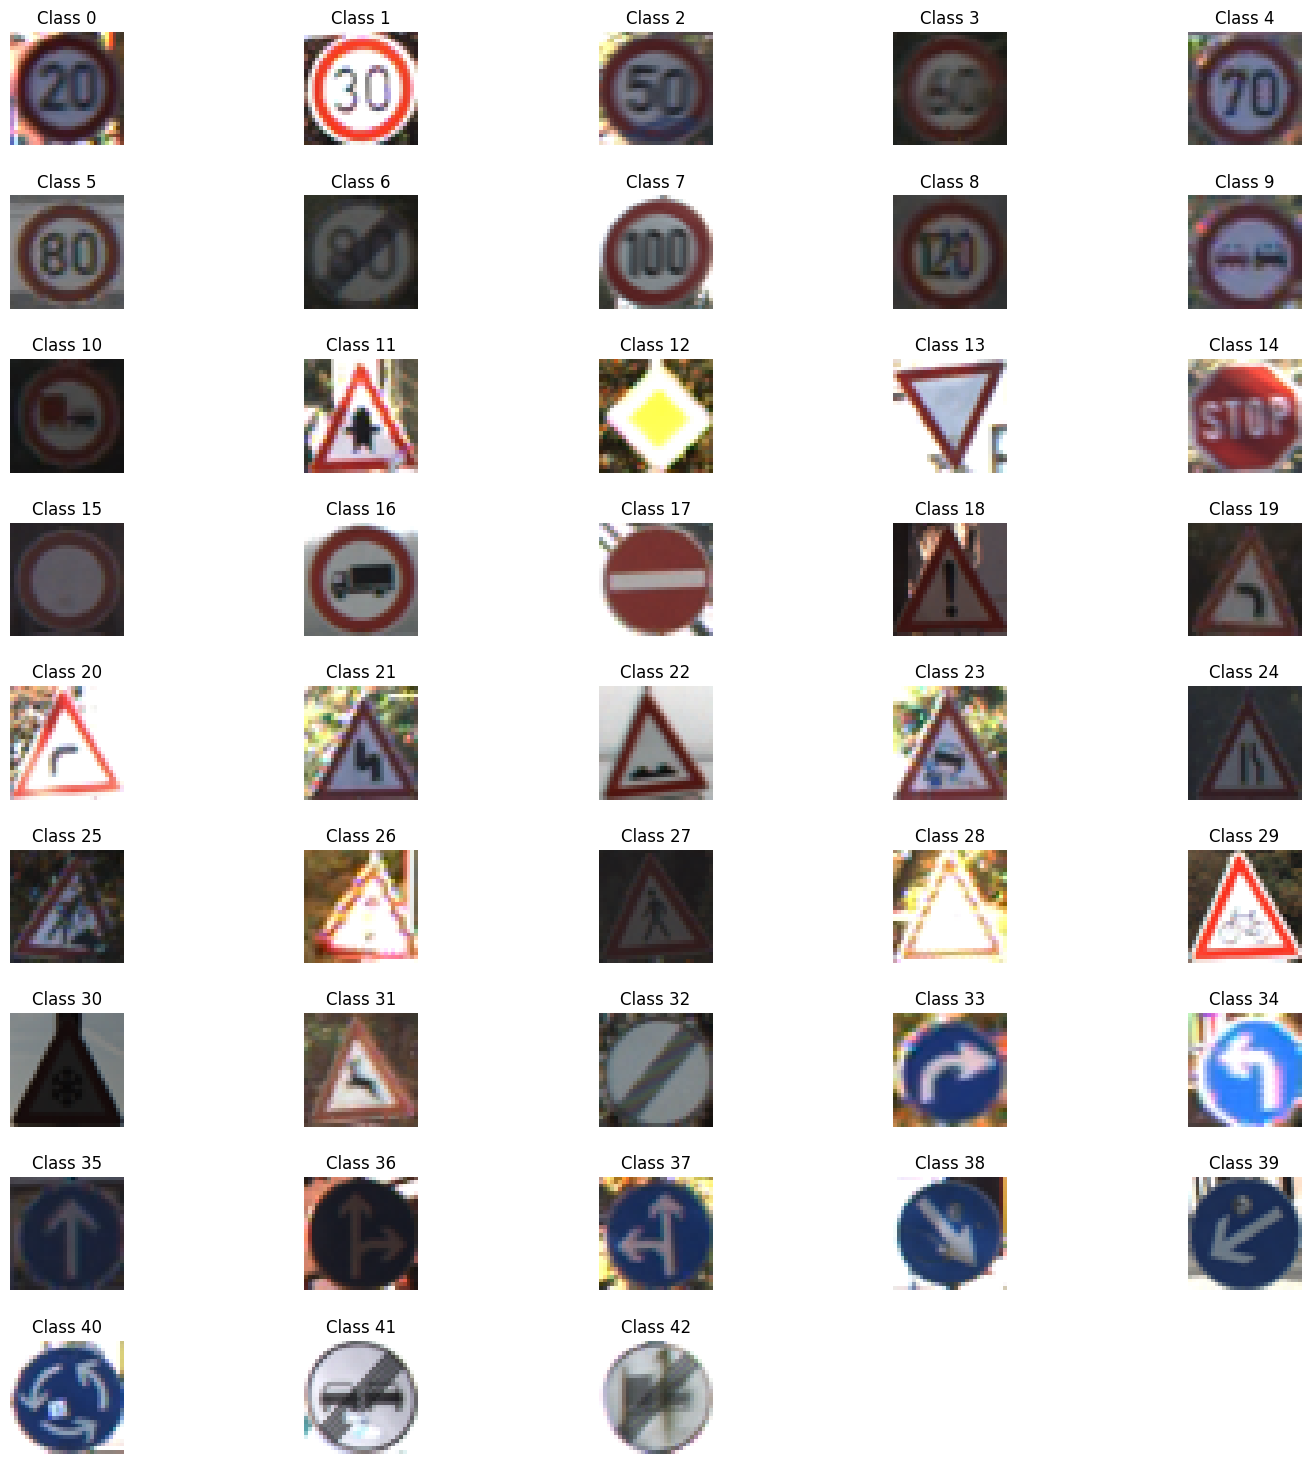

In [44]:

# Plot the samples
plt.figure(figsize=(15, 15))
cols = 5  # Number of columns for the plot
rows = (len(unique_classes) // cols) + (len(unique_classes) % cols > 0)

for i, (class_id, img) in enumerate(class_samples.items()):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"Class {class_id}")
    plt.axis("off")

plt.tight_layout(pad=2.0)
plt.show()


#### Plot the distribution of Classes

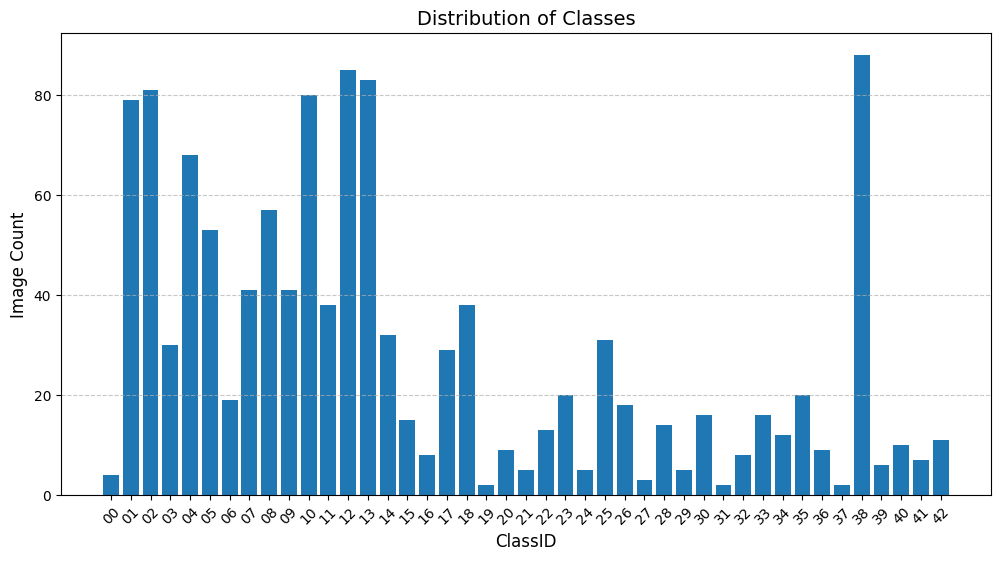

In [77]:
  import os
  import pandas as pd

  # Define the path to the dataset
  data_path = "/content/FullIJCNN2013/FullIJCNN2013/"

  # Initialize a dictionary to store image counts for each class
  class_len_w_class_id = {}

  # Iterate through each folder (class) in the dataset
  for class_id in sorted(os.listdir(data_path)):
      class_folder = os.path.join(data_path, class_id)

      # Ensure it is a folder (skip files, if any)
      if os.path.isdir(class_folder):
          # Count the number of `.ppm` files in the class folder
          num_images = len([f for f in os.listdir(class_folder) if f.endswith('.ppm')])
          class_len_w_class_id[class_id] = num_images

  # Convert the dictionary to a DataFrame
  class_image_frequency_df = pd.DataFrame(list(class_len_w_class_id.items()), columns=["ClassID", "ImageCount"])

  # Display the DataFrame
  # print(class_image_frequency_df)

  # Plot the distribution of classes
  import matplotlib.pyplot as plt

  plt.figure(figsize=(12, 6))
  plt.bar(class_image_frequency_df["ClassID"], class_image_frequency_df["ImageCount"], width=0.8, align='center')
  plt.title("Distribution of Classes", fontsize=14)
  plt.xlabel("ClassID", fontsize=12)
  plt.ylabel("Image Count", fontsize=12)
  plt.xticks(rotation=45)  # Rotate x-axis labels if needed
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.show()


#### Normalize the features

For most image data, the pixel values are integers with values between 0 and 255.

Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values.

Hint: sklearn.preprocessing.normalize

In [82]:
from sklearn.preprocessing import normalize

# Flatten the features to 2D for normalization
features_flattened = features.reshape(features.shape[0], -1)  # Each image as a single row

# Normalize using sklearn
features_normalized = normalize(features_flattened, axis=1)  # Normalize each row (image)

# Reshape the normalized features back to the original shape
features_normalized = features_normalized.reshape(features.shape)

# Features are now normalized using sklearn
print("Shape of normalized features:", features_normalized.shape)


Shape of normalized features: (1213, 30, 30, 3)


###**Excercise 3**
### Train the MLP classifier on features (3 points)

* Split the data into train and test

* Train the MLP classifier with different parameters

* Get the accuracy score and performance metrics



* Define the keras model and initialize the layers
  - Ensure the input layer has the right number of input features. This can be specified when creating the first layer with the input_dim argument.
* Compile the model
  - Specify the loss function (to evaluate a set of weights), the optimizer (is used to search through different weights for the network) and any optional metrics to collect and report during training.
* Fit and Evaluate the model
  - Fit the data by specifying epochs and evaluate the model

In [84]:
# Step 1 - Build the architecture
# Step 1 - Build the architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(features.reshape(features.shape[0], -1),  # Flatten images for MLP
                                                    labels, test_size=0.2, random_state=42)

# Define the number of classes and input features
num_classes = len(np.unique(labels))  # Number of unique classes
input_dim = features.reshape(features.shape[0], -1).shape[1]  # Number of input features (flattened image)

# Convert labels to one-hot encoding
y_train_keras = to_categorical(y_train, num_classes)
y_test_keras = to_categorical(y_test, num_classes)

# Initialize the Keras model
model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))  # Input and first hidden layer
model.add(Dropout(0.2))  # Add dropout for regularization
model.add(Dense(64, activation='relu'))  # Second hidden layer
model.add(Dense(num_classes, activation='softmax'))  # Output layer


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [85]:
# Step 2 - Compile the model
# Step 2 - Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.0767 - loss: 3.6980 - val_accuracy: 0.2222 - val_loss: 3.1987
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1818 - loss: 3.2225 - val_accuracy: 0.2305 - val_loss: 2.9715
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2248 - loss: 2.9666 - val_accuracy: 0.3786 - val_loss: 2.7127
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3179 - loss: 2.7415 - val_accuracy: 0.3786 - val_loss: 2.5778
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3820 - loss: 2.5258 - val_accuracy: 0.4403 - val_loss: 2.2526
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4435 - loss: 2.2467 - val_accuracy: 0.5021 - val_loss: 2.0846
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4909 - loss: 2.0807 - val_accuracy: 0.5144 - val_loss: 1.8852
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5194 - loss: 1.8638 - val_accuracy: 0.5185 - val_loss

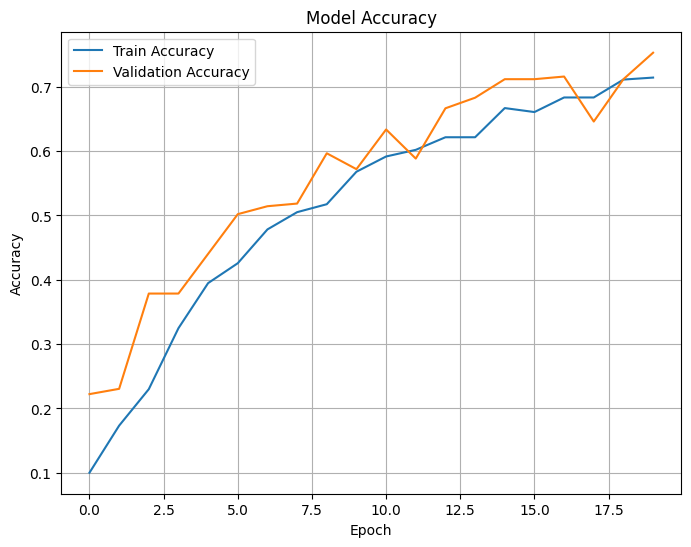

In [86]:
# Step 3 - Fit and Evaluate the model
# Step 3 - Fit and Evaluate the model
from sklearn.model_selection import train_test_split


# Train the model
history = model.fit(X_train, y_train_keras,
                    validation_data=(X_test, y_test_keras),
                    epochs=20, batch_size=32)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_keras)
print("Test Accuracy:", test_accuracy)

# Plot the training and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


#### Try the different algorithms and compare the results with MLP classifier

###**Excercise 4**
### Train a CNN classifier on images (4 points)

* Split the data into train and test

* Train the CNN with 2D convolution and Maxpooling layers

* Get the accuracy score on train and test sets



* Define the keras model and initialize the layers
  - Ensure the input layer is specified with correct image size as input. This can be specified when creating the first layer with the input_shape argument.
* Speicify number of filters Kernel size, Pool size and activation function
  - filters,kernel_size and activation arguments of Conv2D layer can be used
  - pool_size argument of MaxPool2D can be used to set Pool size
* Compile the model
  - Specify the loss function (to evaluate a set of weights), the optimizer (is used to search through different weights for the network) and any optional metrics to collect and report during training.
* Fit and Evaluate the model
  - Fit the data by specifying epochs and evaluate the model

In [89]:
# Step 1 - Build the architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Reshape features for CNN
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)
X_train_cnn = X_train.reshape(-1, resize_dim[0], resize_dim[1], 3)  # Reshape for CNN
X_test_cnn = X_test.reshape(-1, resize_dim[0], resize_dim[1], 3)

# Convert labels to one-hot encoding
num_classes = len(np.unique(labels))
y_train_cnn = to_categorical(y_train, num_classes)
y_test_cnn = to_categorical(y_test, num_classes)

# Initialize the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(resize_dim[0], resize_dim[1], 3)))  # First Conv layer
model.add(MaxPooling2D((2, 2)))  # Pooling layer
model.add(Dropout(0.25))  # Dropout for regularization
model.add(Conv2D(64, (3, 3), activation='relu'))  # Second Conv layer
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())  # Flatten for fully connected layers
model.add(Dense(128, activation='relu'))  # Fully connected layer
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Output layer


In [90]:
# Step 2 - Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.0840 - loss: 3.6589 - val_accuracy: 0.2634 - val_loss: 3.3900
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.1731 - loss: 3.3373 - val_accuracy: 0.3292 - val_loss: 3.0284
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.2428 - loss: 2.9575 - val_accuracy: 0.3745 - val_loss: 2.5544
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3315 - loss: 2.6663 - val_accuracy: 0.3416 - val_loss: 2.3590
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3821 - loss: 2.3042 - val_accuracy: 0.4856 - val_loss: 2.0662
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3939 - loss: 2.1629 - val_accuracy: 0.5103 - val_loss: 1.8900
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4688 - loss: 1.8585 - val_accuracy: 0.5720 - val_loss: 1.6605
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4947 - loss: 1.7347 - val_accuracy: 0.6502 - v

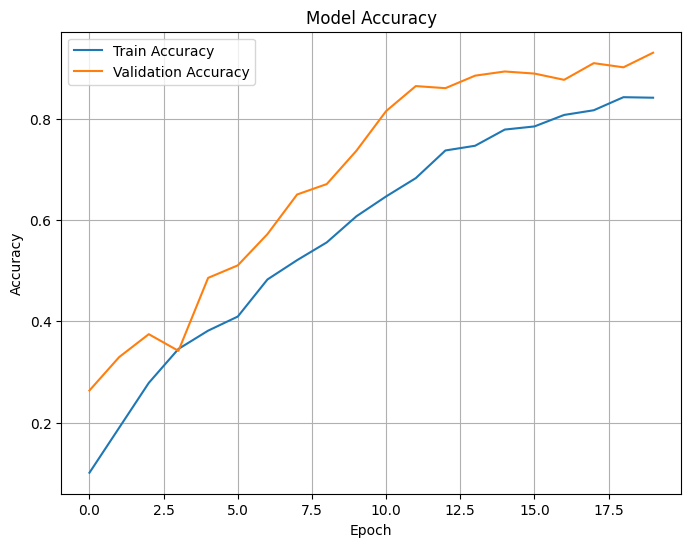

In [91]:
# Step 3 - Fit and Evaluate the model
history = model.fit(
    X_train_cnn,
    y_train_cnn,
    validation_data=(X_test_cnn, y_test_cnn),
    epochs=20,
    batch_size=32,
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test_cnn)
print("Test Accuracy:", test_accuracy)

# Plot the training and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


#### Experiment using Dropout, Regularization and Batch Normalization

#### **MLP**:
- Works well for tabular data or flattened input where features are independent (e.g., structured data, simple image data).
- Can be used for images but is less efficient and less accurate for complex tasks.

#### **CNN**:
- Designed for image data or input with spatial structure.
- Outperforms MLPs in image classification, object detection, and other computer vision tasks.

---

### **Summary Table**

| Aspect                  | **MLP**                                             | **CNN**                                           |
|-------------------------|----------------------------------------------------|-------------------------------------------------|
| **Input Shape**         | Flattened (1D array)                               | 2D or 3D (e.g., 30x30x3 for RGB images)         |
| **Feature Extraction**  | Manual (raw pixel values treated as features)      | Automatic (learns spatial hierarchies)          |
| **Layers**              | Fully connected (`Dense`)                          | Convolutional (`Conv2D`), pooling, dense layers |
| **Efficiency**          | Computationally expensive for large input sizes    | More efficient with shared weights              |
| **Performance on Images** | Limited (good for simple datasets)               | Superior (captures spatial patterns)            |
| **Applications**        | Tabular, text, simple image classification         | Image recognition, object detection             |

---

In [92]:
# Step 1 - Build the architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2  # L2 regularization

# Initialize the CNN model
cnnmodel_optimized = Sequential()

# Add first convolutional layer with Batch Normalization and L2 Regularization
cnnmodel_optimized.add(Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 3), kernel_regularizer=l2(0.01)))
cnnmodel_optimized.add(BatchNormalization())  # Batch Normalization after the convolutional layer
cnnmodel_optimized.add(MaxPooling2D((2, 2)))  # Pooling layer
cnnmodel_optimized.add(Dropout(0.25))  # Dropout for regularization

# Add second convolutional layer
cnnmodel_optimized.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
cnnmodel_optimized.add(BatchNormalization())  # Batch Normalization
cnnmodel_optimized.add(MaxPooling2D((2, 2)))
cnnmodel_optimized.add(Dropout(0.25))  # Dropout

# Flatten the output for dense layers
cnnmodel_optimized.add(Flatten())

# Add dense layers with Dropout and Batch Normalization
cnnmodel_optimized.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
cnnmodel_optimized.add(BatchNormalization())  # Batch Normalization
cnnmodel_optimized.add(Dropout(0.5))  # Dropout for regularization

# Add output layer
cnnmodel_optimized.add(Dense(num_classes, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [93]:
# Step 2 - Compile the model
cnnmodel_optimized.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.1015 - loss: 7.1431 - val_accuracy: 0.0988 - val_loss: 6.4404
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.4106 - loss: 5.1883 - val_accuracy: 0.0864 - val_loss: 6.2239
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.5420 - loss: 4.4131 - val_accuracy: 0.1811 - val_loss: 6.0372
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6655 - loss: 3.6522 - val_accuracy: 0.1852 - val_loss: 5.8918
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7810 - loss: 3.1280 - val_accuracy: 0.1728 - val_loss: 5.8029
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8188 - loss: 2.7846 - val_accuracy: 0.1893 - val_loss: 5.7564
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8633 - loss: 2.5158 - val_accuracy: 0.1852 - val_loss: 5.5754
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8914 - loss: 2.2347 - val_accuracy: 0.1317 -

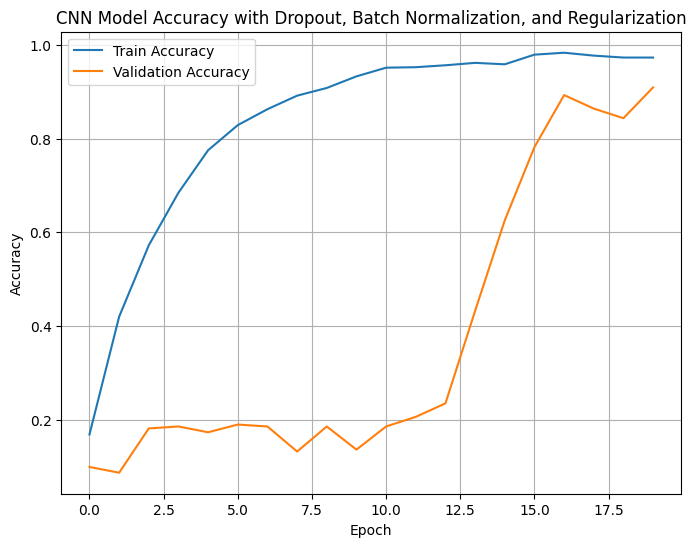

In [94]:
# Step 3 - Fit and Evaluate the model
# Train the CNN model
history = cnnmodel_optimized.fit(
    X_train_cnn,
    y_train_cnn,
    validation_data=(X_test_cnn, y_test_cnn),
    epochs=20,
    batch_size=32,
)

# Evaluate the model
test_loss, test_accuracy = cnnmodel_optimized.evaluate(X_test_cnn, y_test_cnn)
print("Test Accuracy:", test_accuracy)

# Plot the training and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy with Dropout, Batch Normalization, and Regularization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
